# Gibbs sampling

---
# Before Class
In class today we will be implementing a Gibbs Sampler.

Prior to class, please do the following:
1. Review slides on Gibbs sampling in detail
1. Review or read up on Python syntax for:
      1. functions from previous class
      1. `numpy.random.randint()`
      1. `numpy.random.choice()`



---
## Learning Objectives

1. Implement gibbs sampler to locate motifs in B. subtilus promoters


---
## Imports

In [1]:
import numpy as np
import seqlogo

#import function from previous class for building sequence motif & idenfitying seqs matching to motif
from data_readers import *
from seq_ops import get_seq
from motif_ops import *


---
## Implement Gibbs Sampler


Gibbs sampling is a MCMC approach to identify enrichments. Here we will implement a method to identify motifs from a set of regions. 

Important considerations:
- We will need to score each sequence with a PWM using the `score_kmer()` or `score_sequence()` function from the previous class
- These sites are often not strand-specific and so both scores on the negative as well as positive strand should be considered
- To select a random sequence, use `numpy.random.randint()`
- To select a new position $m$ (as defined below) use `numpy.random.choice()`

Assumptions: 
- We know k as the length of expected motif
- Each sequence contains the motif



```
GibbsMotifFinder(DNA, k-length)
    random pick of k-length sequences from each line of DNA as Motifs
    for j ← 1 to 10000 or Motifs stops changing
        i ← Random(N) where N is number of DNA entries
        PWM ← PWM constructed from all Motifs except for Motifi
        Motifi ← select position m from PWM-scored k-mers in DNAi in probabilistic fashion from score distribution
    return PFM
```

Probability of chosing position $m = \frac{A_{m}}{\sum_{l}A_{l}}$ for positions $l$ in DNAi


Note: I have also added a function to `motif_ops.py` that will calculate the information content of your motifs. This is useful to observe the progression of your Gibbs sampler as well as a measure of convergence. You can use this function as `IC = pfm_ic(pfm)`. You should expect a slow increase of IC until it plateaus such as in the plot below from your lecture slides:

<center><img src='./figures/Gibbs_Sampling.png'/ width=600px></center>

In [2]:
def GibbsMotifFinder (seqs, k, seed=42):
    '''
    Function to find a pfm from a list of strings using a Gibbs sampler
    
    Args: 
        seqs (str list): a list of sequences, not necessarily in same lengths
        k (int): the length of motif to find
        seed (int, default=42): seed for np.random

    Returns:
        pfm (numpy array): dimensions are 4xlength
        
    '''
    # Because this is a random walk, we set a seed just so that our results are reproducible
    np.random.seed(2)

    N = len(seqs) #number of sequences input
    
    # First we randomly pick k-length sequences (kmer) from each sequence and place in list motifs to start
    motifs = [] 
    for i in range(N):
        #generate a random index and strand of kmer for each sequence
        index = np.random.randint(len(seqs[i])-k+1)
        strand = np.random.randint(2)
        if strand == 0:
            motifs.append(seqs[i][index:index+k])
        else:
            motifs.append(reverse_complement(seqs[i][index:index+k]))
    
    # Next 10000 iterations or to convergence
    # For my implementation, I define convergence as when the information content of the motif
    # does not change between two measurements that are 100 iterations apart.
    # The logic behind this is that, while there are some fluxuations in the random walk
    # there is a very low chance that nothing will have changed in 100 iterations unless
    # convergence has occured.
    last_ic = None  #Store IC for testing convergence later

    for j in range(10000):
        i = np.random.randint(N) #randomly pick a sequence to be excluded when building motif
                
        # Check for convergence every 100 iterations
        if (j % 100 == 0):
            pfm = build_pfm(motifs,k)  # Build PFM from all motifs
            print(pfm_ic(pfm))         # Output IC
            if last_ic == pfm_ic(pfm): # End if IC from 100 iterations ago is the same as now
                break
            last_ic = pfm_ic(pfm)
        
        # Build a PFM and PWM without the ith sequence that was randomly selected
        pfm = build_pfm(motifs[:i]+motifs[i+1:],k)
        pwm = build_pwm(pfm)

        # Score all kmers in the sequence using our score_kmer() function from last class
        # We do this forward and then backwards and just append the scores and strand to a list.
        # This is similar to the score_nmer() function from last class, but instead of
        # identifying the top score, we just keep track of all of the scores.
        # Using the function score_nmer() from last class would be akin to the hill climbing version
        # of this algorithm.
        scores = []
        strands = []
        for pos in range(len(seqs[i])-k+1):                 # For all of the positions
            score_temp = score_kmer(seqs[i][pos:pos+k],pwm) # Score for the forward strand
            scores.append(score_temp)
            strands.append(0)                               # Strand 0 to represent forward
        
        #Also reverse strand
        for pos in range(len(seqs[i])-k+1):
            score_temp = score_kmer(reverse_complement(seqs[i][pos:pos+k]), pwm) # Score for the negative strand
            scores.append(score_temp)
            strands.append(1)                                                    # Strand 1 to represent negative

        # Now convert scores to 'probabilities' as defined above
        scores = np.exp2(scores) # 2^score to move out of log2 space
        scores_norm = [score/np.sum(scores) for score in scores] # Score / sum scores to generate 'probabilities'
        
        # Choose a new motif location in a probabilistic fashion
        # To do this we draw an index from distribution of motif scores
        # We can just pass our 'probabilies' above to the np.random.choice() function along with the matching indexes for each position
        index_new = np.asscalar(np.random.choice((len(seqs[i])-k+1)*2,1,p=scores_norm))
        strand_new = strands[index_new]
        
        index_new = index_new % (len(seqs[i])-k+1) # Because out index list is twice the length (forward and backward)
                                                   # the new index is actually modulo the length of the number of kmers
                                                   # that were tested in the sequence above.

        # Finally, replace the motif for ith sequence with the probabilistically selected kmer
        if strand_new == 0:
            motifs[i] = seqs[i][index_new:index_new+k]
        else:
            motifs[i] = reverse_complement(seqs[i][index_new:index_new+k])
    
    return pfm

In [3]:
# Here we test your Gibbs sampler.
# You do not need to edit this or the section below

#read promoters from previous class, store in a list of strings
seq_file="../class_04/Data_04/GCF_000009045.1_ASM904v1_genomic.fna.gz"
gff_file="../class_04/Data_04/GCF_000009045.1_ASM904v1_genomic.gff.gz"

seqs = []
for name, seq in get_fasta(seq_file): # For each entry in our FASTA file
    for gff_entry in get_gff(gff_file): # For each entry in our GFF file
        if gff_entry.type == 'CDS': # If this is a coding sequence
            promoter_seq = get_seq(seq, gff_entry.start, gff_entry.end, gff_entry.strand, 50) # Extract 50 bp as a promoter

            # Because the gibbs sampling assumption is broken in just using promoters,
            #  and because it takes very long time to randomly progress through so many
            #  regions, for this example we will pre-filter for sequences that all contain
            #  part of the shine-dalgarno motif:
            if "AGGAGG" in promoter_seq:
                seqs.append(promoter_seq)


0.4619084662869024


/Users/alauth/opt/anaconda3/envs/b529/lib/python3.7/site-packages/ipykernel_launcher.py:79: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


0.5110693136073967
0.5772652128012601
0.6608892560817422
0.782735881048099
0.8425995032494934
0.946546881584921
1.04662925180948
1.1194190130710961
1.2101993983990653
1.2984951186634992
1.4005008159765948
1.4408991631125279
1.575298241336162
1.6431337631023315
1.7249011629952786
1.8061556607193667
1.8764548207761522
1.9645267485523954
2.119112829033948
2.205414711279174
2.2597833104250435
2.376153741778868
2.389050405214577
2.403160613012532
2.4760491227631976
2.550990147576228
2.571234405940246
2.5853076818371297
2.6357073154700226
2.697267545451792
2.756493795813188
2.7897777142533293
2.789306547998012
2.796607385636968
2.8255903532302638
2.845781402777459
2.8649929169724517
2.9142416226640093
2.963181871722773
2.988056945631189
3.0503595653383857
3.059530883665389
3.056668966522109
3.0890375839179383
3.0520488533669257
3.096581412111661
3.1481356071366013
3.1379242132085516
3.1902645070935254
3.204780731811521
3.248017614390042
3.310671487355087
3.3818493236505507
3.470223298109484


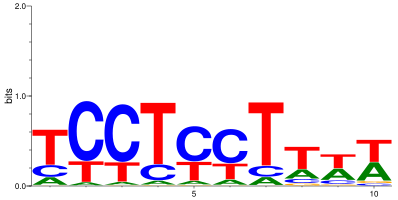

In [4]:
# Run the gibbs sampler:
promoter_pfm = GibbsMotifFinder(seqs,10)

# Plot the final pfm that is generated: 
seqlogo.seqlogo(seqlogo.CompletePm(pfm = promoter_pfm.T))